In [157]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, fbeta_score, roc_curve, roc_auc_score, plot_roc_curve


In [158]:
df = pd.read_csv('UAH-DRIVESET-classification.csv', index_col=0)
df.head()

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,road_type,class_normal,temp_F,humidity_pct,wind_speed_mph,wind_gust_mph,condition,day_night,speed_mph,class_normal_bool
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.955226,0
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.099995,0
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.018755,0
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.811020,0
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,37.524521,0


In [159]:
df['road_type_dummy'] = pd.get_dummies(df['road_type'], drop_first=True)


In [160]:
df['night_dummy'] = pd.get_dummies(df['day_night'], drop_first=True)


# Sub-sample the data for base models, select features

In [161]:
df_sub = df.sample(n=15000, random_state=42)


In [162]:
X = df_sub[['acceleration_score', 'braking_score', 'speeding_score']]
y = df_sub['class_normal_bool']


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [164]:
X_train.shape, y_train.shape

((9000, 3), (9000,))

In [197]:
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# KNN

In [198]:
k_range = list(range(3, 150, 2))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


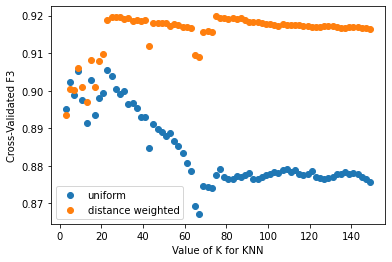

In [199]:
plt.scatter(df_cv[df_cv.param_weights == 'uniform'].param_n_neighbors, df_cv[df_cv.param_weights == 'uniform'].mean_test_score, label='uniform')
plt.scatter(df_cv[df_cv.param_weights == 'distance'].param_n_neighbors, df_cv[df_cv.param_weights == 'distance'].mean_test_score, label='distance weighted')

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F3')

plt.legend();


In [200]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'n_neighbors': 75, 'weights': 'distance'}
Best estimator:  KNeighborsClassifier(n_neighbors=75, weights='distance')
Best score:  0.9198228779308819


# Logit

Cross-val logit

In [201]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.transform(X_val)
X_test_scaled = std_scale.transform(X_test)


In [202]:
C_range = list(np.logspace(-4, 2, 200))

param_grid = dict(C=C_range)

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train_scaled, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


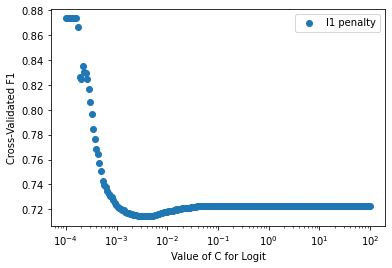

In [203]:
plt.scatter(df_cv.param_C, df_cv.mean_test_score, label='l1 penalty')

plt.xlabel('Value of C for Logit')
plt.ylabel('Cross-Validated F1')

plt.xscale('log')
plt.legend();


In [204]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'C': 0.0001}
Best estimator:  LogisticRegression(C=0.0001)
Best score:  0.8735946459635333


# Decision Tree

In [205]:
max_depth_range = list(range(1,20))
criterion_options = ['entropy', 'gini']
min_samples_split_range = list(range(1,10))
min_samples_leaf_range = list(range(1,5))

param_grid = dict(max_depth=max_depth_range, criterion=criterion_options,
                  min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range)

decisiontree = DecisionTreeClassifier()
grid = GridSearchCV(decisiontree, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.57142833 0.57142833 ... 0.92576469 0.92584889 0.92627762]
  warnings.warn(


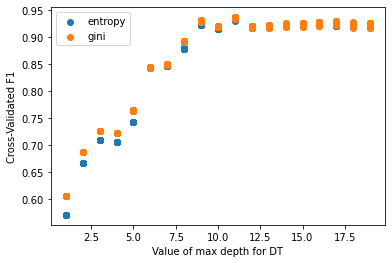

In [206]:
plt.scatter(df_cv[df_cv.param_criterion == 'entropy'].param_max_depth, df_cv[df_cv.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv[df_cv.param_criterion == 'gini'].param_max_depth, df_cv[df_cv.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for DT')
plt.ylabel('Cross-Validated F1')

plt.legend();


In [207]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 7}
Best estimator:  DecisionTreeClassifier(max_depth=11, min_samples_leaf=3, min_samples_split=7)
Best score:  0.9371781032249448


# Random Forest

In [208]:
max_features_options = ['auto', 'sqrt', 'log2']
max_depth_range = list(range(5,10))
criterion_options = ['entropy', 'gini']

param_grid = dict(#n_estimators=n_estimators_range, 
                  max_features=max_features_options,
                  max_depth=max_depth_range, criterion=criterion_options)

randomforest = RandomForestClassifier(n_estimators=100)
grid = GridSearchCV(randomforest, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


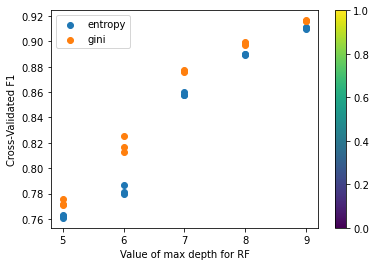

In [209]:
plt.scatter(df_cv[df_cv.param_criterion == 'entropy'].param_max_depth, df_cv[df_cv.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv[df_cv.param_criterion == 'gini'].param_max_depth, df_cv[df_cv.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for RF')
plt.ylabel('Cross-Validated F1')

plt.colorbar()
plt.legend();


In [210]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt'}
Best estimator:  RandomForestClassifier(max_depth=9, max_features='sqrt')
Best score:  0.9166276774409635


**Notes:**

- Used 3 features: acceleration, braking, speeding
- Logistic Regression (F1 score < 0.8) does not perform as well as the other models (all have F1 scores > 0.9)
    - Likely non-linear decision boundary required for classification
    - Decision tree/ensemble models will perform better
- Drop Logistic Regression from further consideration

# Add more features

In [211]:
df_sub.columns

Index(['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'road_type',
       'class_normal', 'temp_F', 'humidity_pct', 'wind_speed_mph',
       'wind_gust_mph', 'condition', 'day_night', 'speed_mph',
       'class_normal_bool', 'road_type_dummy', 'night_dummy'],
      dtype='object')

In [212]:
X = df_sub[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'night_dummy']]
y = df_sub['class_normal_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# KNN (with more features)

In [213]:
k_range = list(range(3, 100, 2))

param_grid = dict(n_neighbors=k_range)

knn = KNeighborsClassifier(weights='distance')
knn_grid = GridSearchCV(knn, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

knn_grid.fit(X_train, y_train)

df_cv_knn = pd.DataFrame(knn_grid.cv_results_)


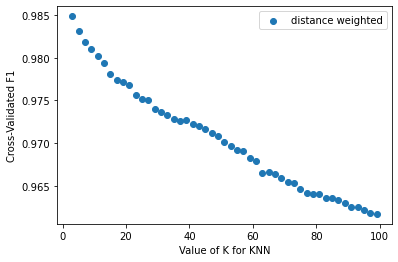

In [214]:
plt.scatter(df_cv_knn.param_n_neighbors, df_cv_knn.mean_test_score, label='distance weighted')

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1')

plt.legend();


In [215]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)


Best params:  {'n_neighbors': 3}
Best estimator:  KNeighborsClassifier(n_neighbors=3, weights='distance')
Best score:  0.9848534921827513


In [233]:
knn = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'], weights='distance')
knn.fit(X_train, y_train)

y_knn_pred = knn.predict(X_val)
y_knn_pred_prob = knn.predict_proba(X_val)[:, 1]

print(f'Accuracy:\t {accuracy_score(y_val, y_knn_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_knn_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_knn_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_knn_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_knn_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_knn_pred):.4f}')


Accuracy:	 0.9797
Precision:	 0.9901
Recall:		 0.9749
F1:		 0.9824
Fbeta (beta=2):	 0.9779
AUC:		 0.9806


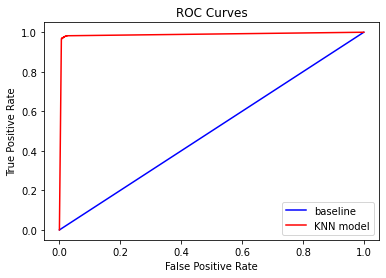

In [230]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_knn_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'KNN model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


# Decision Tree (with more features)

In [218]:
max_depth_range = list(range(5,20))
criterion_options = ['entropy', 'gini']
min_samples_split_range = list(range(2,10))
min_samples_leaf_range = list(range(1,5))

param_grid = dict(max_depth=max_depth_range, criterion=criterion_options,
                  min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range)

decisiontree = DecisionTreeClassifier()
dt_grid = GridSearchCV(decisiontree, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

dt_grid.fit(X_train, y_train)

df_cv_dt = pd.DataFrame(dt_grid.cv_results_)


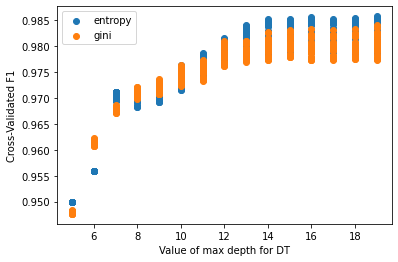

In [219]:
plt.scatter(df_cv_dt[df_cv_dt.param_criterion == 'entropy'].param_max_depth, df_cv_dt[df_cv_dt.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv_dt[df_cv_dt.param_criterion == 'gini'].param_max_depth, df_cv_dt[df_cv_dt.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for DT')
plt.ylabel('Cross-Validated F1')

plt.legend();


In [220]:
print("Best params: ", dt_grid.best_params_)
print("Best estimator: ", dt_grid.best_estimator_)
print("Best score: ", dt_grid.best_score_)


Best params:  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=19)
Best score:  0.9858089695728449


In [234]:
dt = DecisionTreeClassifier(criterion=dt_grid.best_params_['criterion'], max_depth=dt_grid.best_params_['max_depth'], min_samples_leaf=dt_grid.best_params_['min_samples_leaf'], min_samples_split=dt_grid.best_params_['min_samples_split'])
dt.fit(X_train, y_train)

y_dt_pred = dt.predict(X_val)
y_dt_pred_prob = dt.predict_proba(X_val)[:, 1]


print(f'Accuracy:\t {accuracy_score(y_val, y_dt_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_dt_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_dt_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_dt_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_dt_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_dt_pred):.4f}')


Accuracy:	 0.9837
Precision:	 0.9919
Recall:		 0.9800
F1:		 0.9859
Fbeta (beta=2):	 0.9824
AUC:		 0.9844


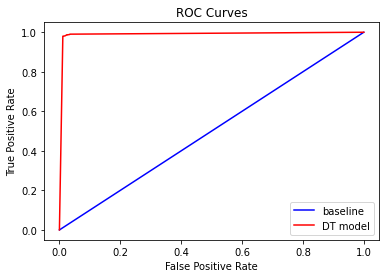

In [232]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_dt_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'DT model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();


# Random Forest (with more features)

In [223]:
max_features_options = ['auto', 'sqrt', 'log2']
max_depth_range = list(range(6,16))
criterion_options = ['entropy', 'gini']

param_grid = dict(max_features=max_features_options,
                  max_depth=max_depth_range, criterion=criterion_options)

randomforest = RandomForestClassifier(n_estimators=100)
rf_grid = GridSearchCV(randomforest, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

rf_grid.fit(X_train, y_train)

df_cv_rf = pd.DataFrame(rf_grid.cv_results_)


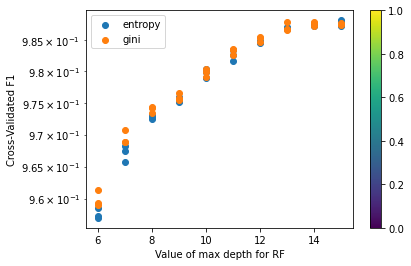

In [224]:
plt.scatter(df_cv_rf[df_cv_rf.param_criterion == 'entropy'].param_max_depth, df_cv_rf[df_cv_rf.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv_rf[df_cv_rf.param_criterion == 'gini'].param_max_depth, df_cv_rf[df_cv_rf.param_criterion == 'gini'].mean_test_score, label='gini')
plt.xlabel('Value of max depth for RF')
plt.ylabel('Cross-Validated F1')

plt.yscale('log')
plt.colorbar()
plt.legend();


In [225]:
print("Best params: ", rf_grid.best_params_)
print("Best estimator: ", rf_grid.best_estimator_)
print("Best score: ", rf_grid.best_score_)


Best params:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt'}
Best estimator:  RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt')
Best score:  0.9881826615326442


In [235]:
rf = RandomForestClassifier(n_estimators=100, criterion=rf_grid.best_params_['criterion'], max_depth=rf_grid.best_params_['max_depth'], max_features=rf_grid.best_params_['max_features'])
rf.fit(X_train, y_train)

y_rf_pred = rf.predict(X_val)
y_rf_pred_prob = rf.predict_proba(X_val)[:, 1]

print(f'Accuracy:\t {accuracy_score(y_val, y_rf_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_rf_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_rf_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_rf_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_rf_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_rf_pred):.4f}')


Accuracy:	 0.9857
Precision:	 0.9948
Recall:		 0.9806
F1:		 0.9876
Fbeta (beta=2):	 0.9834
AUC:		 0.9867


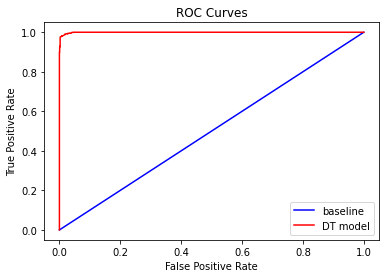

In [236]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_rf_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'DT model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();


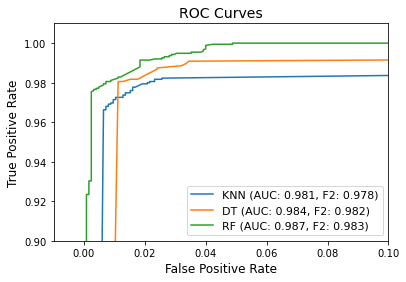

In [244]:
labels = ['KNN', 'DT', 'RF']
y_preds = [y_knn_pred, y_dt_pred, y_rf_pred]
for i,probs in enumerate([y_knn_pred_prob, y_dt_pred_prob, y_rf_pred_prob]):
    base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
    model_fpr, model_tpr, _ = roc_curve(y_val, probs)

    plt.plot(model_fpr, model_tpr, label = f'{labels[i]} (AUC: {roc_auc_score(y_val, y_preds[i]):.3f}, F2: {fbeta_score(y_val, y_preds[i], beta=2):.3f})')

#plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.title('ROC Curves', fontsize=14)

plt.xlim(-0.01,0.1)
plt.ylim(0.90,1.01)

plt.legend(fontsize=11)

plt.savefig('roc_curves_base.png', dpi=300);


**Notes:**

- RF performs slightly better than DT and KNN models
- Will also test an XGBoost model on these features